In [20]:
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

In [13]:
df = pd.read_csv('Breast Cancer Classification.csv')
print(df.shape)
print(df.columns)
print(df.isnull().sum())

(569, 33)
Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst', 'Unnamed: 32'],
      dtype='object')
id                           0
diagnosis                    0
radius_mean                  0
texture_mean                 0
perimeter_mean               0
area_mean                    0
smoothness_mean              0
compactness_mean             0
concavity_mean               0
concave points_mean          0
symmetry_mean  

In [14]:
df.drop(['Unnamed: 32','id'],axis=1,inplace=True)
df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [15]:
X = df.drop(['diagnosis'],axis=1)
y = df['diagnosis'].map({'B': 0, 'M': 1})

In [16]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state = 1)

## Decision Tree Implementation code from the previous lab.

In [17]:

def gini(y):
    """Calculate Gini Impurity"""
    m = len(y)
    if m == 0:
        return 0
    proportions = np.bincount(y) / m
    return 1 - np.sum(proportions ** 2)

def entropy(y):
    """Calculate Entropy"""
    m = len(y)
    if m == 0:
        return 0
    proportions = np.bincount(y) / m
    return -np.sum([p * np.log2(p) for p in proportions if p > 0])

def best_split(X, y, criterion='gini'):
    """Find the best feature and threshold to split on"""
    best_feature, best_threshold, best_score = None, None, float('inf')
    m, n = X.shape

    for feature in range(n):
        thresholds = np.unique(X[:, feature])
        for threshold in thresholds:
            left_mask = X[:, feature] <= threshold
            right_mask = ~left_mask
            left_y, right_y = y[left_mask], y[right_mask]

            if len(left_y) == 0 or len(right_y) == 0:
                continue

            if criterion == 'gini':
                impurity = (len(left_y) * gini(left_y) + len(right_y) * gini(right_y)) / m
            elif criterion == 'entropy':
                impurity = (len(left_y) * entropy(left_y) + len(right_y) * entropy(right_y)) / m
            else:
                raise ValueError("Invalid criterion. Choose 'gini' or 'entropy'.")

            if impurity < best_score:
                best_feature, best_threshold, best_score = feature, threshold, impurity

    return best_feature, best_threshold

def build_tree(X, y, depth=0, max_depth=None, min_samples_split=2, criterion='gini'):
    """Recursively build the decision tree"""
    num_samples, num_features = X.shape

    # Stopping criteria
    if (max_depth is not None and depth == max_depth) or (num_samples < min_samples_split) or (len(set(y)) == 1):
        return np.argmax(np.bincount(y))  # Return majority class

    feature, threshold = best_split(X, y, criterion)
    if feature is None:
        return np.argmax(np.bincount(y))

    left_mask = X[:, feature] <= threshold
    right_mask = ~left_mask

    return {
        'feature': feature,
        'threshold': threshold,
        'left': build_tree(X[left_mask], y[left_mask], depth + 1, max_depth, min_samples_split, criterion),
        'right': build_tree(X[right_mask], y[right_mask], depth + 1, max_depth, min_samples_split, criterion)
    }

def predict_single(x, tree, features):
    """Predict a single sample"""
    # Convert x to a pandas Series if it's not already for feature lookup
    x = pd.Series(x, index=features) if not isinstance(x, pd.Series) else x

    if isinstance(tree, dict):
        feature_val = x[tree['feature']]
        if feature_val <= tree['threshold']:
            return predict_single(x, tree['left'], features)
        else:
            return predict_single(x, tree['right'], features)
    return tree

def predict(X, tree, features):
    """Predict multiple samples"""
    # Convert X to NumPy array if it is a DataFrame for compatibility
    X_np = X.to_numpy() if isinstance(X, pd.DataFrame) else X
    return np.array([predict_single(sample, tree, features) for sample in X_np])



## Random Forest Classifier Implementation from scratch.

In [18]:

def create_Bootstrapped_Subsets(X,y,num_subsets,subset_size,feature_fraction):
  subsets = []
  num_features = X.shape[1]
  num_samples = X.shape[0]
  for i in range(num_subsets):
    sample_indices = np.random.choice(num_samples, size=int(num_samples*subset_size), replace=True)

    X_subset = X.iloc[sample_indices]
    y_subset = y.iloc[sample_indices]

    feature_indices = np.random.choice(num_features, size=int(num_features * feature_fraction), replace=True)
    X_subset = X_subset.iloc[:, feature_indices]

    subsets.append((X_subset, y_subset, feature_indices))
  return subsets


def build_random_forest(X, y, num_trees, subset_size, feature_fraction, max_depth=None, min_samples_split=2, criterion='gini'):
    subsets = create_Bootstrapped_Subsets(X, y, num_trees, subset_size, feature_fraction)
    forest = []
    for X_subset, y_subset, feature_indices in subsets:
        tree = build_tree(X_subset.to_numpy(), y_subset.to_numpy(), max_depth=max_depth, min_samples_split=min_samples_split, criterion=criterion)
        forest.append((tree, feature_indices))
    return forest


def predict_random_forest(X, forest, features):
    predictions = []
    for tree, feature_indices in forest:
        X_subset = X.iloc[:, feature_indices]
        tree_prediction = predict(X_subset, tree, features[feature_indices])
        predictions.append(tree_prediction)
    return predictions


def majority_vote(predictions):
    sample_predictions = np.array(predictions).T     # Transposing the predictions to get predictions for each sample
    final_predictions = []
    for sample in sample_predictions:
        majority_class = Counter(sample).most_common(1)[0][0]
        final_predictions.append(majority_class)
    return np.array(final_predictions)


In [19]:
np.random.seed(1)

num_trees = 100
subset_size = 0.7
feature_fraction = 0.7
forest = build_random_forest(Xtrain, ytrain, num_trees, subset_size, feature_fraction, max_depth=5, min_samples_split=2, criterion='gini')

predictions = predict_random_forest(Xtest, forest, Xtest.columns)
final_predictions = majority_vote(predictions)


report = classification_report(ytest, final_predictions)
print(report)

<ipython-input-17-85f401b88fe5>:72: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  feature_val = x[tree['feature']]


              precision    recall  f1-score   support

           0       0.95      0.94      0.95       108
           1       0.91      0.92      0.91        63

    accuracy                           0.94       171
   macro avg       0.93      0.93      0.93       171
weighted avg       0.94      0.94      0.94       171



Visualizing Tree 1:


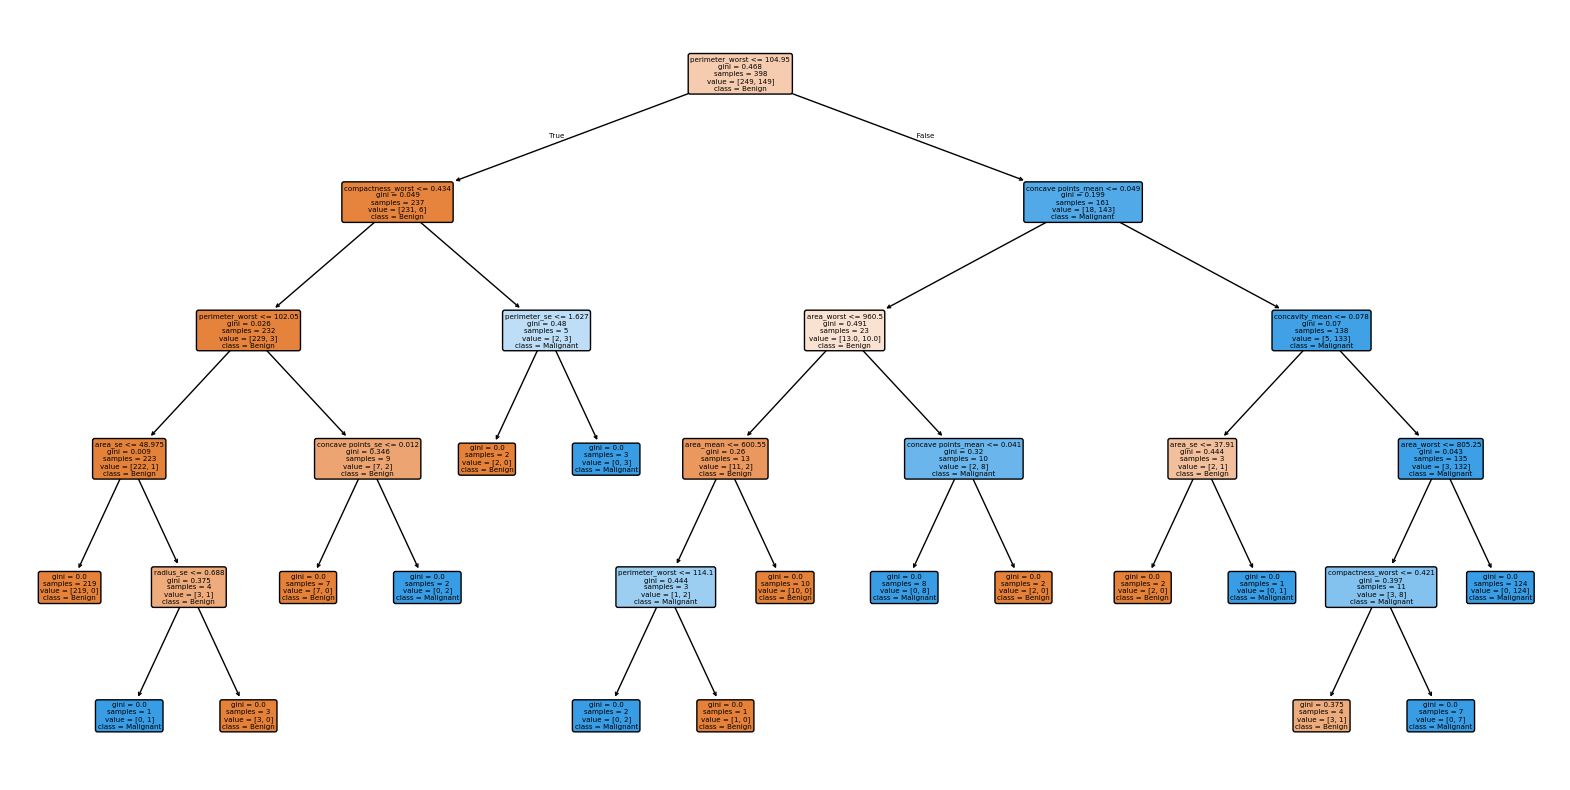

Visualizing Tree 2:


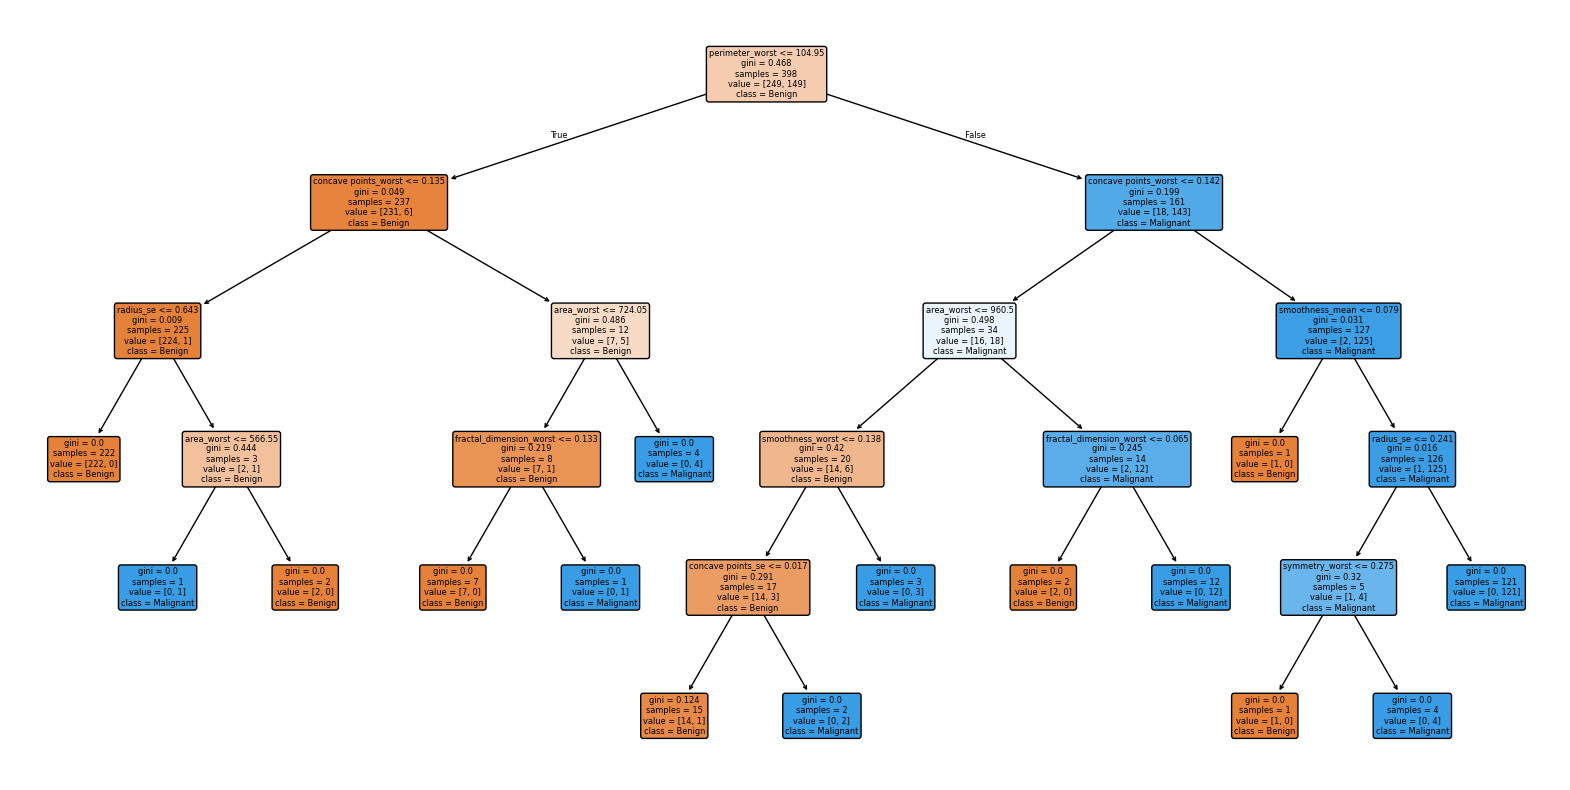

Visualizing Tree 3:


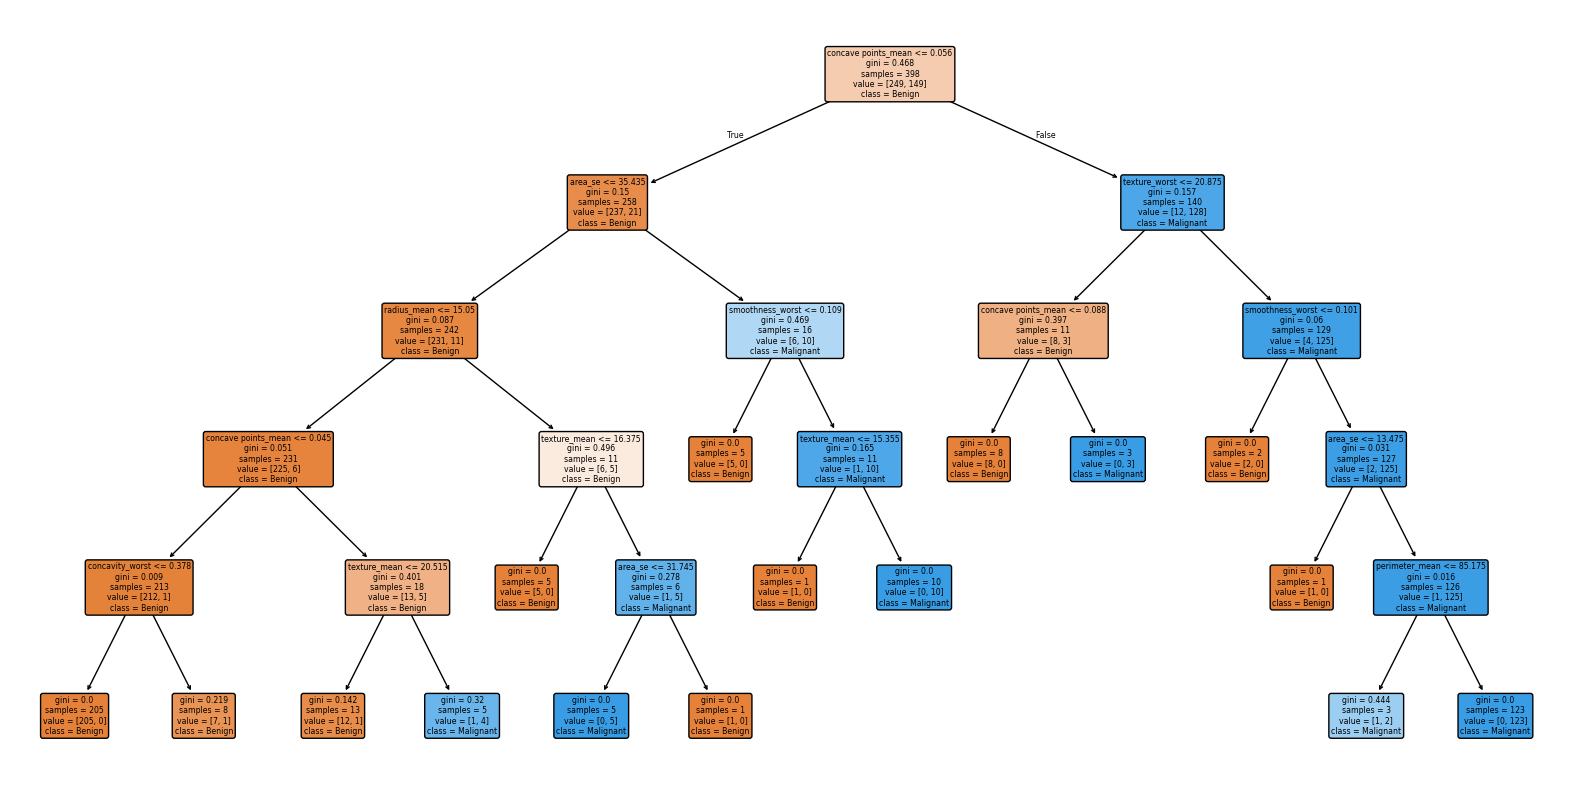

In [23]:

def visualize_tree(tree, feature_names):
    plt.figure(figsize=(20, 10))
    plot_tree(tree, feature_names=feature_names, filled=True, rounded=True, class_names=['Benign', 'Malignant'])
    plt.show()

for i in range(3): # visualizing 3 trees out of the 100 trees
    tree, feature_indices = forest[i] # using trees stored in the forest variable of the random forest classifier in the above cell.

    tree_feature_names = Xtest.columns[feature_indices]

    from sklearn.tree import DecisionTreeClassifier
    temp_tree = DecisionTreeClassifier(max_depth=5) # using temporary decision tree model since it is required in order to use sklearn's plot tree
    X_subset = Xtrain.iloc[:, feature_indices]
    temp_tree.fit(X_subset, ytrain)

    print(f"Visualizing Tree {i+1}:")
    visualize_tree(temp_tree, tree_feature_names)
